## 🔍 Crawl Data and Sentiment Analysis Tweets "Vaksinasi Covid Surabya" in Bahasa 🩺


# Pre-Processing

In [40]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')

import nest_asyncio
nest_asyncio.apply()


import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [41]:
tweets = pd.read_csv('/content/Tuntutan_rakyat_17+8 - Tuntutan_rakyat_17+8.csv.crdownload')

tweets.head()

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1.963753e+18,Thu Sep 04 23:55:06 +0000 2025,0,Dari sekian banyak bahasan 17+8 tuntutan rakyat yg disenggol korupsinya. Definisi tone deaf bgt tu bocah mana pro 02 juga cuih,1.963753e+18,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/1963752713256395127,1059593600,NaN
1,1.963752e+18,Thu Sep 04 23:51:35 +0000 2025,2,Hari ini deadline 17+8 tuntutan rakyat #KawalSampaiMenang,1.963752e+18,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/1963751829935993247,1856170626563891200,NaN
2,1.963745e+18,Thu Sep 04 23:23:18 +0000 2025,16,ngerayain ultah pas deadline indo dengan tuntutan rakyat 17+8 https://t.co/9YuZX2a5JG,1.963745e+18,https://pbs.twimg.com/media/G0CfZv5acAEyS2M.jpg,NaN,in,NaN,2,57,0,https://x.com/undefined/status/1963744711740686806,1868280869448003584,NaN
3,1.963741e+18,Thu Sep 04 23:08:39 +0000 2025,3,17+8 itu apa toh? Ini bener ya? Kok gak ada 'adili si Nganu' Kuatkan KPK kok tuntutannya tetap gak substansial? Kita itu bermasalah dengan Kebodohan DPR terus kok jadi berpindah jadi Kebodohan Influencer? #IndonesiaCapeDeh https://t.co/C06T11QzxJ,1.963741e+18,NaN,NaN,in,NaN,0,1,0,https://x.com/undefined/status/1963741023383032065,57574639,NaN
4,1.963631e+18,Thu Sep 04 23:02:35 +0000 2025,0,@imwinteoa Ini tanda tangan bahwa dokumen yg berisi 17+8 tuntutan rakyat sudah diterima oleh perwakilan DPR. Kawal terus,1.963739e+18,NaN,imwinteoa,in,NaN,0,0,0,https://x.com/undefined/status/1963739496064888995,1603283936091656192,NaN


In [42]:
import re
import string
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory


# 1. Bersihkan teks dari mention, hashtag, URL dll

def normalize_text(text):
    text = re.sub(r'@\w+', '', text)              # hapus mention
    text = re.sub(r'#\w+', '', text)              # hapus hashtag
    text = re.sub(r'\bRT\b', '', text)            # hapus retweet tag
    text = re.sub(r'http\S+|www\.\S+', '', text)  # hapus url
    text = re.sub(r'\d+', '', text)               # hapus angka

    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text.strip()


# 2. Lowercase seluruh teks

def lower_text(text):
    return text.lower()


# 3. Tokenisasi

def split_tokens(text):
    return word_tokenize(text)


# 4. Hapus stopwords

def remove_stopwords(tokens):
    remover = StopWordRemoverFactory().create_stop_word_remover()
    cleaned = remover.remove(" ".join(tokens))
    return cleaned.split()


# 5. Stemming

def apply_stemming(tokens):
    stemmer = StemmerFactory().create_stemmer()
    return [stemmer.stem(t) for t in tokens]


# 6. Ubah daftar token kembali menjadi kalimat

def join_tokens(tokens):
    return " ".join(tokens)


# Emoji dictionary (sama makna, beda variabel dan struktur)

emoji_map = {
    ':)': 'smile', ':-)': 'smile', ';d': 'wink', ':(': 'sad', ':-(': 'sad',
    ':P': 'raspberry', ':O': 'surprised', ':-@': 'shocked', ':@': 'shocked',
    ":\\": 'annoyed', ':#': 'mute', ':X': 'mute', ':-D': 'smile',
    'O.o': 'confused', ';-)': 'wink', ';)': 'wink', ':-0': 'yell',
    ":'-)": 'sadsmile', 'd[-_-]b': 'dj', '=^.^=': 'cat'
}


# 7. Ganti emoji dengan kata

def convert_emoji(item):
    if isinstance(item, str):
        for emo, desc in emoji_map.items():
            item = item.replace(emo, f"EMOJI_{desc}")
        return item

    if isinstance(item, list):
        return [convert_emoji(t) for t in item]

    return item

In [43]:
import nltk

# Cek dan unduh tokenizer
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt')
    nltk.download('punkt_tab')

# Pipeline preprocessing
# Tahap 1: Normalisasi teks
tweets['text_clean'] = tweets['full_text'].apply(normalize_text)

# Tahap 2: Lowercase
tweets['text_clean'] = tweets['text_clean'].apply(lower_text)

# Tahap 3: Tokenisasi
tweets['tokens'] = tweets['text_clean'].apply(split_tokens)

# Tahap 4: Konversi emoji
tweets['tokens'] = tweets['tokens'].apply(convert_emoji)

# Tahap 5: Stopword removal
tweets['tokens'] = tweets['tokens'].apply(remove_stopwords)

# Tahap 6: Stemming
tweets['tokens'] = tweets['tokens'].apply(apply_stemming)


In [44]:
# drop duplicates/spams tweets
tweets.drop_duplicates(subset = 'text_clean', inplace = True)

kolom = ['conversation_id_str',	'created_at',	'favorite_count', 'full_text', 'id_str',	'image_url',	'in_reply_to_screen_name',	'lang', 'location', 'quote_count', 'reply_count', 'retweet_count', 'tweet_url',	'user_id_str',	'username']
tweets_clean = tweets.drop(columns=kolom)

# Export to csv file
tweets_clean.to_csv('Tuntutan 17+18 preprocessed.csv', index = False, header = True,index_label=None)

In [45]:
tweets = pd.read_csv('/content/Tuntutan 17+18 preprocessed.csv')

for i, text in enumerate(tweets['tokens']):
    tweets['tokens'][i] = tweets['tokens'][i].replace("'", "")\
                                            .replace(',','').replace(']','').replace('[','')
    list_words=[]
    for word in tweets['tokens'][i].split():
        list_words.append(word)

    tweets['tokens'][i] = list_words

tweets.head(10)

/tmp/ipython-input-1462982751.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  tweets['tokens'][i] = tweets['tokens'][i].replace("'", "")\
/tmp/ipython-input-1462982751.py:10: FutureWarning: ChainedAssignmentError: behaviour will change i

,text_clean,tokens
0,dari sekian banyak bahasan tuntutan rakyat yg disenggol korupsinya definisi tone deaf bgt tu bocah mana pro juga cuih,"[sekian, banyak, bahas, tuntut, rakyat, yg, senggol, korupsi, definisi, tone, deaf, bgt, tu, bocah, mana, pro, cuih]"
1,hari ini deadline tuntutan rakyat,"[hari, deadline, tuntut, rakyat]"
2,ngerayain ultah pas deadline indo dengan tuntutan rakyat,"[ngerayain, ultah, pas, deadline, indo, tuntut, rakyat]"
3,itu apa toh ini bener ya kok gak ada adili si nganu kuatkan kpk kok tuntutannya tetap gak substansial kita itu bermasalah dengan kebodohan dpr terus kok jadi berpindah jadi kebodohan influencer,"[apa, ini, bener, kok, gak, adil, si, nganu, kuat, kpk, kok, tuntut, tetap, gak, substansial, itu, masalah, bodoh, dpr, terus, kok, jadi, pindah, jadi, bodoh, influencer]"
4,ini tanda tangan bahwa dokumen yg berisi tuntutan rakyat sudah diterima oleh perwakilan dpr kawal terus,"[tanda, tangan, dokumen, yg, isi, tuntut, rakyat, terima, wakil, dpr, kawal, terus]"
5,enak pak mentang kita terkenal dengan bangsa yang berbudaya sopan santun apa harus diam saja rakyat sudah nurut th tertipu dan sampean ada dalam pemerintahan itu wiranto ungkap respon prabowo soal tuntutan rakyat tak serentak semua dipenuhi,"[enak, pak, mentang, kenal, bangsa, budaya, sopan, santun, apa, diam, rakyat, nurut, th, tipu, sampean, dalam, perintah, wiranto, ungkap, respon, prabowo, soal, tuntut, rakyat, tak, serentak, semua, penuh]"
6,tuntutan rakyat dari andovijerome dkk dari media sosial dibahas di dpr,"[tuntut, rakyat, andovijerome, dkk, media, sosial, bahas, dpr]"
7,yo tuntutan rakyat itu beneran diserahin ke dpr kemarin isinya jangka pendek deadline sept sama jangka panjang sampai agustus soal reformasi polisi partai ekonomi dll pengaruh agenda rahasia parpol bisa jadi soalnya pdipgerindra lagi kolab ketat,"[yo, tuntut, rakyat, beneran, diserahin, dpr, kemarin, isi, jangka, pendek, deadline, sept, sama, jangka, panjang, agustus, soal, reformasi, polisi, partai, ekonomi, pengaruh, agenda, rahasia, parpol, jadi, soal, pdipgerindra, kolab, ketat]"
8,intine tuntutan rakyat wis diserahke menyang dpr pdip lan gerindra lagi mesra tenan saling dukung ing saben kesempatan di dpr kaya mbatalake ruu pilkada nggawe ruu tni lan pertemuan ketum parpol kayane megapro lagi mekar maneh mesthi ana koncokonco kenthel ora,"[intine, tuntut, rakyat, wis, diserahke, nyang, dpr, pdip, lan, gerindra, mesra, tenan, saling, dukung, ing, saben, sempat, dpr, kaya, mbatalake, ruu, pilkada, nggawe, ruu, tni, lan, temu, tum, parpol, kayane, megapro, mekar, maneh, mesthi, ana, koncokonco, kenthel, ora]"
9,wild guess karena pengalaman panjangnya di dpr dan untuk menjaga keseimbangan kekuasaan antar partai terutama pdip dan gerindra biar bisa kolaborasi tangani tuntutan rakyat seperti itu,"[wild, guess, alam, panjang, dpr, untuk, jaga, imbang, kuasa, antar, partai, utama, pdip, gerindra, biar, kolaborasi, tangan, tuntut, rakyat, itu]"


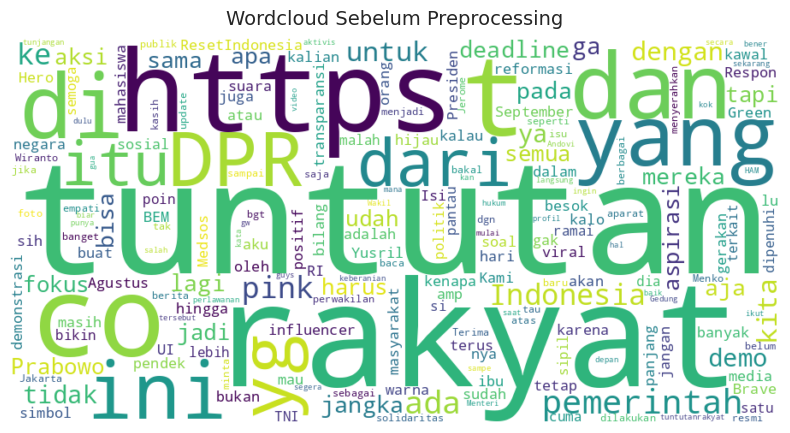

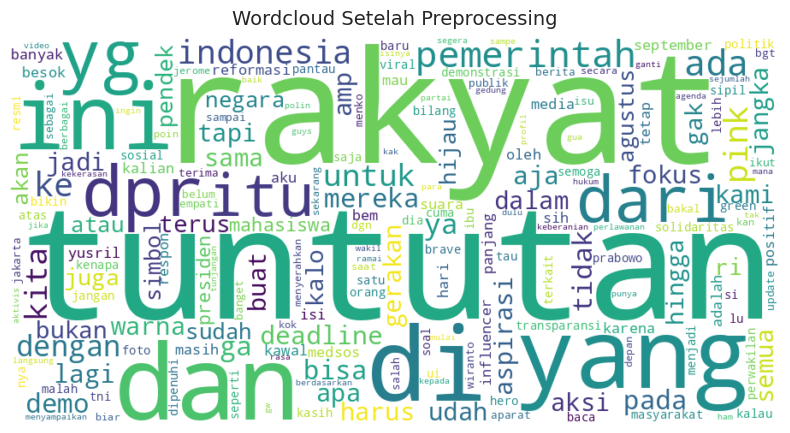

In [47]:
# Fungsi untuk menampilkan word cloud

def show_wordcloud(text_data, title_text):
    wc = WordCloud(
        width=900,
        height=450,
        background_color="white",
        collocations=False
    ).generate(text_data)

    plt.figure(figsize=(11, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.title(title_text, fontsize=14, pad=10)
    plt.axis("off")
    plt.show()


# Membaca dataset

df = pd.read_csv('/content/Tuntutan_rakyat_17+8 - Tuntutan_rakyat_17+8.csv.crdownload')


# Wordcloud sebelum preprocessing
raw_text = " ".join(df['full_text'].astype(str))
show_wordcloud(raw_text, "Wordcloud Sebelum Preprocessing")
# Wordcloud setelah preprocessing
processed_text = " ".join(tweets['text_clean'].astype(str))
show_wordcloud(processed_text, "Wordcloud Setelah Preprocessing")


Berdasarkan visualisasi di atas, dapat disimpulkan bahwa `elemen tidak relevan` seperti https, t, co, ini, yg, ke, dll sudah berhasil terhapus. Oleh karena itu, hasil akhir dari pre-processing data pada visualisasi sebelah kanan sudah siap digunakan.

# Sentiment Polarity

In [48]:
import csv

# Membaca lexicon dari file CSV
lexicon_map = {}

with open('/content/modified_full_lexicon.csv', 'r', encoding='utf-8') as f:
    csv_reader = csv.reader(f)
    next(csv_reader, None)  # skip header

    for entry in csv_reader:
        term = entry[0]
        value = int(entry[1])
        lexicon_map[term] = value


# Fungsi analisis sentimen berbasis lexicon
def classify_sentiment(tokens):
    total = 0

    for token in tokens:
        if token in lexicon_map:
            total += lexicon_map[token]

    if total > 0:
        label = "positive"
    elif total < 0:
        label = "negative"
    else:
        label = "neutral"

    return total, label


Pada proses ini, Kami menggunakan data lexicon dengan bahasa Indonesia dari sumber `GitHub`.

In [49]:
# Menghitung sentimen untuk setiap baris pada kolom 'tokens'
sentiment_output = tweets['tokens'].apply(classify_sentiment)

# Memisahkan skor dan label
sentiment_score, sentiment_label = zip(*sentiment_output)

# Memasukkan ke DataFrame
tweets['sentiment_score'] = sentiment_score
tweets['sentiment_class'] = sentiment_label

# Menampilkan jumlah tiap kategori sentimen
print(tweets['sentiment_class'].value_counts())

# Menampilkan DataFrame lengkap
tweets


sentiment_class
negative    433
positive     32
neutral      16
Name: count, dtype: int64


,text_clean,tokens,sentiment_score,sentiment_class
0,dari sekian banyak bahasan tuntutan rakyat yg disenggol korupsinya definisi tone deaf bgt tu bocah mana pro juga cuih,"[sekian, banyak, bahas, tuntut, rakyat, yg, senggol, korupsi, definisi, tone, deaf, bgt, tu, bocah, mana, pro, cuih]",-5,negative
1,hari ini deadline tuntutan rakyat,"[hari, deadline, tuntut, rakyat]",-3,negative
2,ngerayain ultah pas deadline indo dengan tuntutan rakyat,"[ngerayain, ultah, pas, deadline, indo, tuntut, rakyat]",-3,negative
3,itu apa toh ini bener ya kok gak ada adili si nganu kuatkan kpk kok tuntutannya tetap gak substansial kita itu bermasalah dengan kebodohan dpr terus kok jadi berpindah jadi kebodohan influencer,"[apa, ini, bener, kok, gak, adil, si, nganu, kuat, kpk, kok, tuntut, tetap, gak, substansial, itu, masalah, bodoh, dpr, terus, kok, jadi, pindah, jadi, bodoh, influencer]",-32,negative
4,ini tanda tangan bahwa dokumen yg berisi tuntutan rakyat sudah diterima oleh perwakilan dpr kawal terus,"[tanda, tangan, dokumen, yg, isi, tuntut, rakyat, terima, wakil, dpr, kawal, terus]",-9,negative
...,...,...,...,...
476,dkk ayo dong bangsat minta maaf temuin rakyat kerjain tuntutan mau sampe berapa banyak lagi sih korbannya,"[dkk, ayo, dong, bangsat, minta, maaf, temuin, rakyat, kerjain, tuntut, mau, sampe, berapa, banyak, sih, korban]",-21,negative
477,hai tren foto berwarna pink dan sering digabung hijau lagi viral di medsos indonesia sebagai simbol gerakan tuntutan rakyat atau reset indonesia pink melambangkan keberanian dan perlawanan terhadap ketidakadilan terinspirasi dari sosok ibuibu pemberani banyak yang,"[hai, tren, foto, warna, pink, sering, gabung, hijau, viral, medsos, indonesia, simbol, gera, tuntut, rakyat, reset, indonesia, pink, melambang, berani, lawan, ketidakadilan, inspirasi, sosok, ibuibu, berani, banyak]",-8,negative
478,vox populi vox dei suara rakyat adalah suara tuhan alarm demokrasi berbunyi reset sistem yang keset tuntutan adalah keniscayaan dan harapan harapan masa depan indonesia kepada pemangku kebijakan mohon kebijaksanaan,"[vox, populi, vox, dei, suara, rakyat, suara, tuhan, alarm, demokrasi, bunyi, reset, sistem, keset, tuntut, niscaya, harap, harap, masa, depan, indonesia, mang, bijak, mohon, bijaksana]",-27,negative
479,warna pink dan hijau dipilih mewakili daftar tuntutan rakyat yang,"[warna, pink, hijau, pilih, wakil, daftar, tuntut, rakyat]",-5,negative


In [50]:
tweets.to_csv('/content/tweets_sentiment.csv', index=False)

### Data Visualization

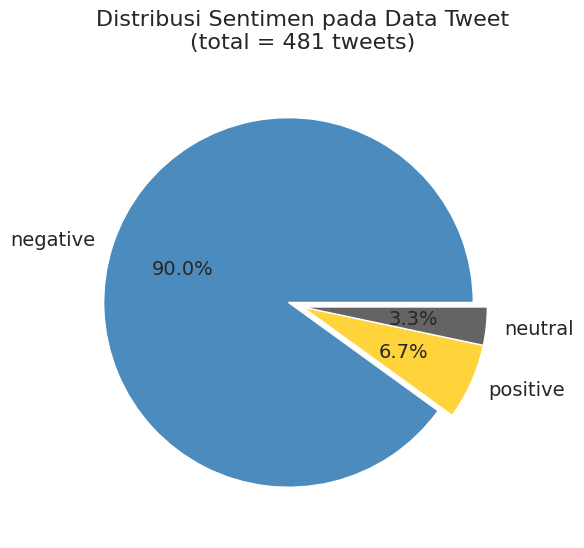

In [51]:
# Mengatur figure
fig, axis = plt.subplots(figsize=(6, 6))

# Hitung distribusi sentimen
sent_counts = tweets['sentiment_class'].value_counts()

# Data untuk grafik
values = sent_counts.values
categories = sent_counts.index.tolist()
color_set = ['#4B8BBE', '#FFD43B', '#646464']

# Explode (opsional)
explode_cfg = [0.08] + [0] * (len(categories) - 1)

# Plot pie
axis.pie(
    values,
    labels=categories,
    autopct='%1.1f%%',
    explode=explode_cfg,
    colors=color_set,
    textprops={'fontsize': 14}
)

axis.set_title(
    f"Distribusi Sentimen pada Data Tweet\n(total = {len(tweets)} tweets)",
    fontsize=16,
    pad=20
)

plt.show()

In [55]:
# Menampilkan kolom teks panjang
pd.set_option('display.max_colwidth', 3000)

# Filter: hanya tweet sentimen positif
top_positive = (
    tweets[tweets['sentiment_class'] == 'positive']               # kolom sudah diganti di versi sebelumnya
    .loc[:, ['text_clean', 'sentiment_score', 'sentiment_class']] # pilih kolom
    .sort_values('sentiment_score', ascending=False)              # urutkan skor tertinggi
    .reset_index(drop=True)                                       # reset index
)

top_positive.index = top_positive.index + 1
top_positive.head(10)


,text_clean,sentiment_score,sentiment_class
1,hari ini dpr resmi menggelar rapat dengan pimpinan fraksi membahas tuntutan rakyat poin moral yang mendesak direspons cepat mulai dari kasus affan kurniawan keterlibatan tni di urusan sipil hingga transparansi anggaran dpr dan evaluasi tunjangan,11,positive
2,pmii menilai penyampaian aspirasi langsung kepada presiden prabowo merupakan langkah strategis dibandingkan hanya melalui jalur legislatif,7,positive
3,tuntutan rakyat berhasil atau mustahil interupsi bersama davie pratama narasumber aryanto sutadi ⁠muhammad qadari ⁠muhamad isnur ⁠okki sutanto kamis september wib live hanya di inews,7,positive
4,menko yusril pastikan pemerintah tanggapi positif tuntutan rakyat,7,positive
5,yusril menko kumham pastikan pemerintah respons positif tuntutan rakyat,7,positive
6,yusril pastikan pemerintah akan respons positif tuntutan rakyat,7,positive
7,yusril pastikan pemerintah respons positif tuntutan rakyat,7,positive
8,fenomena pemasangan foto profil pink hijau ini berbarengan dengan kampanye tuntutan rakyat di medsos kampanye tersebut muncul pasca rentetan aksi protes yang terjadi sejak akhir agustus lalu,7,positive
9,berdasarkan info terkini hingga september presiden prabowo menyatakan telah mendengar tuntutan rakyat dari aksi agustus beberapa yang direspons pembekuan kenaikan tunjangangaji dpr moratorium perjalanan luar negeri anggota dpr dan penghentian tunjangan rumah,5,positive
10,guys ayo kawal dan pantau terus respons pemerintah terhadap tuntutan kita rakyat gokil cong rakyat selucu dan sekreatif ini masih aja dijahati check n recheck on link belowww,5,positive


In [56]:
# Mengatur tampilan panjang teks
pd.set_option('display.max_colwidth', 3000)
# Seleksi tweet negatif dan pilih kolom yang dibutuhkan
worst_negative = (
    tweets[tweets['sentiment_class'] == 'negative']
    .loc[:, ['text_clean', 'sentiment_score', 'sentiment_class']]
    .sort_values('sentiment_score', ascending=True)
    .head(10)
    .reset_index(drop=True)
)
worst_negative.index = worst_negative.index + 1
worst_negative


,text_clean,sentiment_score,sentiment_class
1,wkwkwkk di ganti merah putih sekalian aja ganti jadi merah hitam biar kayak poster the conjuring tapi terserah mau merah putih kek kuning abu abu kek yang penting tuntutan rakyat,-54,negative
2,adanya tuntutan yg dirumushin beberapa org itu kan baru sebagian kecil dari yg diminta rakyat bukan gambaran general keseluruhan kalo ada kurang bisa disampaikan utk tambahan poin tuntutan lanjutannya jd jgn terlalu sensi bagus ada yg gercep ini malah pada sensi aneh,-51,negative
3,klo kt presiden sy ada antek antek asing yg berusaha mengadu domba sy udh khatam bgt ini diadu domba gini bayangin aja rakyat demoin dpr eh pemerintah media parcok parjo ribet berantem salahan cari dalang kerusuhan dibanding menuhin tuntutan,-49,negative
4,pengen gw jawab saya mendoakan keadilan bagi seluruh rakyat indonesia tanpa memandang agama manapun semoga para pemangku kebijakan dapat membuka mata dan hatinya terhadap tuntutan rakyat serta tidak lagi semenamena dalam mengambil keputusan demi keuntungan pribadinya,-45,negative
5,fokusnya mending ke tuntutan rakyat itu deh drpd mencoba mencari celah dari org yg turun aksi isi hati orang gaada yg tau tapi husnudzon kalau beliau smsm berjuang buat rakyat kayaknya gak bikin rugi kamu,-41,negative
6,stop bikin keributan sendiri stop ngeributin sesuatu yg ga perlu diributin fokus sama substansinya fokus sama isi tuntutan rakyat biar semua orang tau biar makin rame ini malah ngeributin warna ga jelas lu edit aja sana sendiri warna ijo abu monyet,-41,negative
7,gelombang protes publik berkumandang di dunia maya lewat unggahan tuntutan rakyat sejak sabtu unggahan yang memuat total tuntutan ditujukan kepada presiden dpr partai politik polri dan tni isinya antara lain mendesak pembebasan seluruh demonstran yang,-41,negative
8,temen lakilaki di kelas ada yang bilang kenapa pada ganti ava jadi ada pink nya gitu sih terus gw bilang kan ya itu buat yang demo tuntutan rakyat dia jawab lagi ya kenapa ada pink nya gw cuma diem doang terus mikir yaallah sosmed ada yang bahas,-40,negative
9,wah anj nambah lagi beban pikiran tolong lah icaa hey lu teh bego jangan di pelihara beneran gak belajar dari yang sebelumnya gua mau nonton tds dengan tenang anj ini aja gua masih waswas sama status tuntutan rakyat besok kayak gimana si ica malah mengada ulah,-38,negative
10,harusnya jangan demo dasar rakyat goblok udah tau influencer dan seleb sudah mewakilu kalian lewat tuntutan rakyat malah tetep pengen demo tolong hargai keadaan kelas menengah sudah mulai tenang dan negara udah mulai kompak sama mereka rakyat kecil tolong diam tunggu,-38,negative


In [57]:


from wordcloud import WordCloud
import matplotlib.pyplot as plt


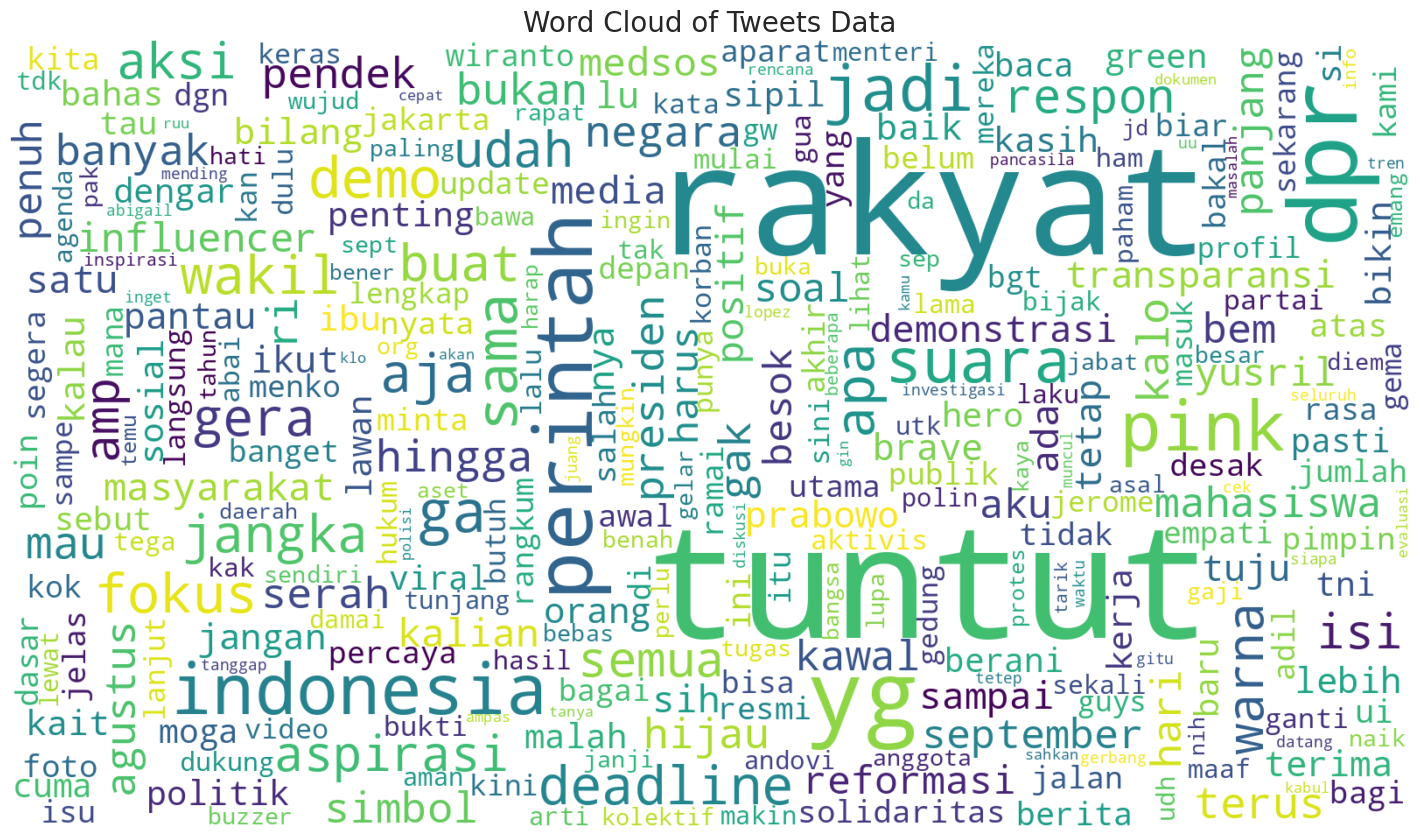

In [58]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Gabungkan semua kata
list_words = ' '.join([' '.join(tweet) for tweet in tweets['tokens']])

# Wordcloud style lebih profesional
wordcloud = WordCloud(
    width=1600,
    height=900,
    background_color='white',
    colormap='viridis',          # warna profesional mirip contoh
    prefer_horizontal=0.7,       # lebih banyak teks horizontal
    max_words=300,
    min_font_size=5,
    max_font_size=180,
    collocations=False,          # supaya kata tidak duplikat
    margin=2                     # kata lebih rapat
).generate(list_words)

# Visualisasi
plt.figure(figsize=(14, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Word Cloud of Tweets Data", fontsize=20)
plt.show()


#Modeling

In [59]:
tweets = pd.read_csv('/content/tweets_sentiment.csv')

In [60]:
tweets

,text_clean,tokens,sentiment_score,sentiment_class
0,dari sekian banyak bahasan tuntutan rakyat yg disenggol korupsinya definisi tone deaf bgt tu bocah mana pro juga cuih,"['sekian', 'banyak', 'bahas', 'tuntut', 'rakyat', 'yg', 'senggol', 'korupsi', 'definisi', 'tone', 'deaf', 'bgt', 'tu', 'bocah', 'mana', 'pro', 'cuih']",-5,negative
1,hari ini deadline tuntutan rakyat,"['hari', 'deadline', 'tuntut', 'rakyat']",-3,negative
2,ngerayain ultah pas deadline indo dengan tuntutan rakyat,"['ngerayain', 'ultah', 'pas', 'deadline', 'indo', 'tuntut', 'rakyat']",-3,negative
3,itu apa toh ini bener ya kok gak ada adili si nganu kuatkan kpk kok tuntutannya tetap gak substansial kita itu bermasalah dengan kebodohan dpr terus kok jadi berpindah jadi kebodohan influencer,"['apa', 'ini', 'bener', 'kok', 'gak', 'adil', 'si', 'nganu', 'kuat', 'kpk', 'kok', 'tuntut', 'tetap', 'gak', 'substansial', 'itu', 'masalah', 'bodoh', 'dpr', 'terus', 'kok', 'jadi', 'pindah', 'jadi', 'bodoh', 'influencer']",-32,negative
4,ini tanda tangan bahwa dokumen yg berisi tuntutan rakyat sudah diterima oleh perwakilan dpr kawal terus,"['tanda', 'tangan', 'dokumen', 'yg', 'isi', 'tuntut', 'rakyat', 'terima', 'wakil', 'dpr', 'kawal', 'terus']",-9,negative
...,...,...,...,...
476,dkk ayo dong bangsat minta maaf temuin rakyat kerjain tuntutan mau sampe berapa banyak lagi sih korbannya,"['dkk', 'ayo', 'dong', 'bangsat', 'minta', 'maaf', 'temuin', 'rakyat', 'kerjain', 'tuntut', 'mau', 'sampe', 'berapa', 'banyak', 'sih', 'korban']",-21,negative
477,hai tren foto berwarna pink dan sering digabung hijau lagi viral di medsos indonesia sebagai simbol gerakan tuntutan rakyat atau reset indonesia pink melambangkan keberanian dan perlawanan terhadap ketidakadilan terinspirasi dari sosok ibuibu pemberani banyak yang,"['hai', 'tren', 'foto', 'warna', 'pink', 'sering', 'gabung', 'hijau', 'viral', 'medsos', 'indonesia', 'simbol', 'gera', 'tuntut', 'rakyat', 'reset', 'indonesia', 'pink', 'melambang', 'berani', 'lawan', 'ketidakadilan', 'inspirasi', 'sosok', 'ibuibu', 'berani', 'banyak']",-8,negative
478,vox populi vox dei suara rakyat adalah suara tuhan alarm demokrasi berbunyi reset sistem yang keset tuntutan adalah keniscayaan dan harapan harapan masa depan indonesia kepada pemangku kebijakan mohon kebijaksanaan,"['vox', 'populi', 'vox', 'dei', 'suara', 'rakyat', 'suara', 'tuhan', 'alarm', 'demokrasi', 'bunyi', 'reset', 'sistem', 'keset', 'tuntut', 'niscaya', 'harap', 'harap', 'masa', 'depan', 'indonesia', 'mang', 'bijak', 'mohon', 'bijaksana']",-27,negative
479,warna pink dan hijau dipilih mewakili daftar tuntutan rakyat yang,"['warna', 'pink', 'hijau', 'pilih', 'wakil', 'daftar', 'tuntut', 'rakyat']",-5,negative


In [ ]:
def toSentence(tokens):
    try:
        return " ".join(tokens)
    except:
        return ""

In [61]:
# Make text preprocessed (tokenized) to untokenized with toSentence Function
X = tweets['tokens'].apply(toSentence)
max_features = 5000

# Tokenizer
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)

# Padding
X = pad_sequences(X)
X.shape


(481, 276)

In [63]:
# Convert polarity labels to numeric values
label_mapping = {
    'negative': 0,
    'neutral' : 1,
    'positive': 2
}

y = tweets['sentiment_class'].replace(label_mapping).to_numpy()

# Split dataset into training and testing set (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    shuffle=True,
    stratify=y,
    random_state=42
)

print("Train shape :", X_train.shape, y_train.shape)
print("Test shape  :", X_test.shape, y_test.shape)


Train shape : (384, 276) (384,)
Test shape  : (97, 276) (97,)


/tmp/ipython-input-807028671.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = tweets['sentiment_class'].replace(label_mapping).to_numpy()


In [64]:
# Encode target data into numerical values
polarity_encode = {'negative' : 0, 'neutral' : 1, 'positive' : 2}
y = tweets['sentiment_class'].map(polarity_encode).values

# Split the data (with composition data train 80%, data test 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(384, 276) (384,)
(97, 276) (97,)


In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert the tokenized and padded sequences back to text
X_train_text = [' '.join(map(str, seq)) for seq in X_train]
X_test_text = [' '.join(map(str, seq)) for seq in X_test]

# TF/IDF
vectoriser = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
vectoriser.fit(X_train_text)

# Transform the data
X_train_tfidf = vectoriser.transform(X_train_text)
X_test_tfidf = vectoriser.transform(X_test_text)

print(f'X_train_tfidf shape: {X_train_tfidf.shape}')
print(f'X_test_tfidf shape: {X_test_tfidf.shape}')

X_train_tfidf shape: (384, 276)
X_test_tfidf shape: (97, 276)


#### Logistic Regression

In [66]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

modelLR = LogisticRegression()

parameters = [
  {'penalty': ['l1', 'l2', 'none'], 'solver': ['saga']},
  {'penalty': ['l2', 'none'], 'solver': ['sag']},
 ]

modelLR1 = GridSearchCV(modelLR, parameters, cv=5)
modelLR1.fit(X_train_tfidf, y_train)

print("best parameters: {}".format(modelLR1.best_params_))
print("best score:      {:0.5f}".format(modelLR1.best_score_))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

best parameters: {'penalty': 'l1', 'solver': 'saga'}
best score:      0.90366


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assuming X_train, X_test, y_train, y_test are your training and test data

# Create a logistic regression model
logreg_model = LogisticRegression(penalty='l2', solver='sag')

# Train the model
logreg_model.fit(X_train_tfidf, y_train)

LogisticRegression(solver='sag')

In [68]:
# Make predictions on the test set
y_pred_log = logreg_model.predict(X_test_tfidf)

# Evaluate the accuracy of the model
accuracy_log = accuracy_score(y_test, y_pred_log)
print(f'Accuracy: {accuracy_log * 100:.2f}%')

Accuracy: 90.72%


In [69]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_log)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred_log)
print("\nClassification Report:")
print(class_report)


Confusion Matrix:
[[86  0  0]
 [ 2  0  0]
 [ 7  0  2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        86
           1       0.00      0.00      0.00         2
           2       1.00      0.22      0.36         9

    accuracy                           0.91        97
   macro avg       0.64      0.41      0.44        97
weighted avg       0.90      0.91      0.88        97



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Random Forest

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define the Random Forest model
rf_model = RandomForestClassifier()

# Set the parameters to be tuned
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_

best_params

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [71]:
# Train the Random Forest model with the best parameters
best_rf_model = RandomForestClassifier(n_estimators=100, max_depth= None, min_samples_leaf=1, min_samples_split=2)
best_rf_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_rf = best_rf_model.predict(X_test_tfidf)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 90.72%


In [72]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred_rf)
print("\nClassification Report:")
print(class_report)


Confusion Matrix:
[[86  0  0]
 [ 2  0  0]
 [ 7  0  2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        86
           1       0.00      0.00      0.00         2
           2       1.00      0.22      0.36         9

    accuracy                           0.91        97
   macro avg       0.64      0.41      0.44        97
weighted avg       0.90      0.91      0.88        97



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### XGBoost

In [73]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Define the XGBoost model
xgb_model = XGBClassifier()

# Set the parameters to be tuned
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_

best_params

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}

In [74]:
from xgboost import XGBClassifier

# Train the XGBoost model with the best parameters
best_xgb_model = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100)
best_xgb_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_xgb = best_xgb_model.predict(X_test_tfidf)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 90.72%


In [75]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred_xgb)
print("\nClassification Report:")
print(class_report)


Confusion Matrix:
[[86  0  0]
 [ 2  0  0]
 [ 7  0  2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        86
           1       0.00      0.00      0.00         2
           2       1.00      0.22      0.36         9

    accuracy                           0.91        97
   macro avg       0.64      0.41      0.44        97
weighted avg       0.90      0.91      0.88        97



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
